In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

#MODELPATH = '/content/gdrive/My Drive/Colab Notebooks/yai7_CV1/modelsave/'

#IMAGEWOOFPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagewoof2'

IMAGENETTEPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagenette2'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("torch version:", torch.__version__)
print("check device:", torch.cuda.get_device_name())
print("how many?:", torch.cuda.device_count())
print("so can i use it?", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch version: 1.7.0+cu101
check device: Tesla P100-PCIE-16GB
how many?: 1
so can i use it? True


In [5]:
# transformation for CIFAR 10
# yet to implement standard color augmentation

train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.RandomCrop(224, padding=28),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

test_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),         
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

In [ ]:
"""train_set = torchvision.datasets.ImageFolder(root=IMAGENETTEPATH+'/train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root=IMAGENETTEPATH+'/val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')"""

train_loader 296
test_loader 123


In [8]:
from google.colab import output
!mkdir "./train"
!mkdir "./val"
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/train.zip" "train.zip"
!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/val.zip" "val.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "train.zip" -d "./train/"
!unzip "val.zip" -d "./val/"

Streaming output truncated to the last 5000 lines.
  inflating: ./train/n03445777/n03445777_8446.JPEG  
  inflating: ./train/n03445777/n03445777_8448.JPEG  
  inflating: ./train/n03445777/n03445777_8474.JPEG  
  inflating: ./train/n03445777/n03445777_8477.JPEG  
  inflating: ./train/n03445777/n03445777_8484.JPEG  
  inflating: ./train/n03445777/n03445777_8544.JPEG  
  inflating: ./train/n03445777/n03445777_8546.JPEG  
  inflating: ./train/n03445777/n03445777_8599.JPEG  
  inflating: ./train/n03445777/n03445777_8616.JPEG  
  inflating: ./train/n03445777/n03445777_8624.JPEG  
  inflating: ./train/n03445777/n03445777_8628.JPEG  
  inflating: ./train/n03445777/n03445777_866.JPEG  
  inflating: ./train/n03445777/n03445777_8663.JPEG  
  inflating: ./train/n03445777/n03445777_8677.JPEG  
  inflating: ./train/n03445777/n03445777_8678.JPEG  
  inflating: ./train/n03445777/n03445777_8679.JPEG  
  inflating: ./train/n03445777/n03445777_8683.JPEG  
  inflating: ./train/n03445777/n03445777_8694.JPE

In [10]:
train_set = torchvision.datasets.ImageFolder(root='./train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root='./val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')

train_loader 296
test_loader 123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


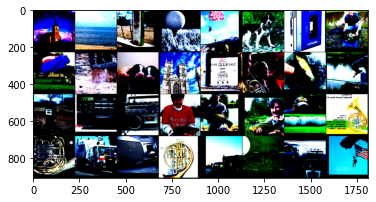

In [11]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [12]:
# define the basic building blocks for ResNet

# option A
class Padding(nn.Module):
    def __init__(self, in_c, out_c):
        super(Padding, self).__init__()
        self.padding = F.pad
        self.pad_dim = (out_c - in_c) / 2

    def forward(self, x):
        x = self.padding(x, (0,0,0,0, self.pad_dim, self.pad_dim), "constant", 0)
        return x

# option Mine
class Concat(nn.Module):
    def __init__(self, in_c, out_c):
        super(Concat, self).__init__()
        
        self.dim_remainder = (out_c - in_c) % in_c
        self.concat_times = (out_c - in_c) // in_c


    def forward(self, x):

        cat_x = [x] * self.concat_times
        cat_x = torch.cat(cat_x, dim=0)
        cat_x = torch.cat((cat_x, x[:self.dim_remainder]), dim=0)

        return cat_x

class BuildingBlock(nn.Module):

    def __init__(self, in_c, out_c, stride=1, option='B'):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.shortcut = nn.Sequential()
        if in_c != out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, out_c)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [13]:
class Bottleneck(nn.Module):

    def __init__(self, in_c, process_c, stride=1, option='B'):
        super(Bottleneck, self).__init__()

        self.out_c = process_c * 4

        self.conv1 = nn.Conv2d(in_c, process_c, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(process_c)

        self.conv2 = nn.Conv2d(process_c, process_c, kernel_size=3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(process_c)

        self.conv3 = nn.Conv2d(process_c, self.out_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(self.out_c)

        self.shortcut = nn.Sequential()
        if in_c != self.out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, self.out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, self.out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(self.out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, self.out_c)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        # slightly changed for CIFAR10
        # in order to have dimension 32x32 --> 16x16
        self.conv_gate = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn_gate = nn.BatchNorm2d(64)
        self.maxpool_gate = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn_gate(self.conv_gate(x)))
        x = self.maxpool_gate(x)
        return x

In [14]:
class ResNet18B_Bottleneck(nn.Module):
    def __init__(self):
        super(ResNet18B_Bottleneck, self).__init__()

        self.gate = Gate()

        self.conv2_1 = Bottleneck(in_c=64, process_c=64, stride=1, option='B')
        self.conv2_2 = Bottleneck(256, 64, 1, 'B')

        self.conv3_1 = Bottleneck(256, 128, 2, 'B')
        self.conv3_2 = Bottleneck(512, 128, 1, 'B')

        self.conv4_1 = Bottleneck(512, 256, 2, 'B')
        self.conv4_2 = Bottleneck(1024, 256, 1, 'B')

        self.conv5_1 = Bottleneck(1024, 512, 2, 'B')
        self.conv5_2 = Bottleneck(2048, 512, 1, 'B')

        self.output = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.gate(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        #print("5", x.shape)

        # slight change from 3 --> 2
        x = F.avg_pool2d(x, 7)
        #print("avgpool", x.shape)

        x = x.view(-1, 2048)
        #print("fc", x.shape)
        x = self.output(x)

        return x

In [15]:
resnet = ResNet18B_Bottleneck()
resnet.to(device)

ResNet18B_Bottleneck(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [16]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #print(m)
        init.kaiming_normal_(m.weight)
        #torch.nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        #print(m)
        init.kaiming_normal_(m.weight)
        init.zeros_(m.bias)

    # no initialization for BatchNorm2d

In [17]:
resnet.apply(weights_init)

ResNet18B_Bottleneck(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [18]:
def train_one_epoch(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    length = len(train_loader)
    running_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        pred = model(image)
        loss = loss_function(pred, label)
    
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_loss is {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : loss {running_loss/length:.4f}')


def eval_one_epoch(model, test_loader, epoch):
    model.eval()
    length = len(test_loader)
    running_acc = 0.0

    for i, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.numpy()

        pred = model(image)
        pred_label = pred.argmax(axis=1).detach().cpu().numpy()
        running_acc += (pred_label==label).mean()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_acc is {running_acc/(i+1):.4f}')

    val_acc = running_acc/length

    print(f'epoch {epoch} : acc {val_acc:.4f}')

    return val_acc

In [19]:
# hyperparameters from paper
# assuming same for pretraining

learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
epochs = 100

In [20]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, 
                            momentum=momentum, weight_decay=weight_decay)

milestones = [60, 80]

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.1
)

# 391 iterations per epoch
# 32k iter = 82 epochs
# 42k iter = 108 epochs
# 64k iter = 164 epochs

In [21]:
val_acc_list = []

for epoch in range(epochs):
    train_one_epoch(resnet, train_loader, loss_function, optimizer, epoch)
    val_acc_list.append(eval_one_epoch(resnet, test_loader, epoch))
    scheduler.step()

after looking at 128 images, running_loss is 3.6569
after looking at 6528 images, running_loss is 3.6332
after looking at 12928 images, running_loss is 3.2279
after looking at 19328 images, running_loss is 3.0045
after looking at 25728 images, running_loss is 2.7859
after looking at 32128 images, running_loss is 2.6387
epoch 0 : loss 2.5278
after looking at 128 images, running_acc is 0.3438
after looking at 6528 images, running_acc is 0.3775
after looking at 12928 images, running_acc is 0.3738
epoch 0 : acc 0.4033
after looking at 128 images, running_loss is 1.7381
after looking at 6528 images, running_loss is 1.8098
after looking at 12928 images, running_loss is 1.7726
after looking at 19328 images, running_loss is 1.7479
after looking at 25728 images, running_loss is 1.7237
after looking at 32128 images, running_loss is 1.6955
epoch 1 : loss 1.6777
after looking at 128 images, running_acc is 0.8438
after looking at 6528 images, running_acc is 0.5312
after looking at 12928 images, run

In [22]:
val_acc_list

[0.40327380952380953,
 0.5607820363917926,
 0.6164343786295006,
 0.6398083623693379,
 0.6734659310878822,
 0.6982554200542006,
 0.7320581687959736,
 0.7076558265582656,
 0.7282229965156795,
 0.7486933797909407,
 0.5961212737127372,
 0.7380226480836236,
 0.7834881920247774,
 0.7611304684475416,
 0.7896946380178088,
 0.782338850174216,
 0.8067653890824623,
 0.7889445412311266,
 0.8092939411536972,
 0.762291908633372,
 0.7953082655826559,
 0.8155245838172668,
 0.7803184281842819,
 0.8080236159504453,
 0.8132379984514131,
 0.8047086720867209,
 0.8338051684088269,
 0.7923804684475416,
 0.8048296554394115,
 0.8392736159504453,
 0.8345673635307781,
 0.8268244289585753,
 0.8376403406891211,
 0.8033294618660473,
 0.7756121757646148,
 0.8280826558265583,
 0.8382452574525746,
 0.8468955671699574,
 0.8276955090979481,
 0.8509364111498258,
 0.8287117692605498,
 0.8510936895083236,
 0.852605981416957,
 0.8322686798296555,
 0.8312403213317847,
 0.8414392179636082,
 0.8674748354626404,
 0.835474738675

In [ ]:
torch.randn([128, 512, 2, 2])

In [ ]:
torch.cat(cat, dim=0).shape

In [ ]:
torch.cat((t4d, t4d), dim=0)

In [ ]:
F.pad(t4d, (1,1,1,1,4,4))

In [ ]:
F.avg_pool2d(torch.randn([128, 512, 2, 2]), 2)

In [ ]:
6